In [1]:
# data
# model
# loss
# eval
# infer


In [2]:
# 目标是先建立一个非常强的baseline；数据端先简易来；模型端好好弄，loss好好弄， eval好好弄;

1. data
    1.1 bbox 2 mask; 
        probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
                    Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
        labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
            
    1.2 由于数据端是bbox, 如果不用rcnn，而使用Unet, 那么你必须改造bbox2mask, 我想先从损失端来好一些，这样你知道mask的格式对于多分类是什么。
    1.3 搞定了，但是要验证一下，两个东西1.画rectangle 完成 2.画mask 完成;
    1.4 最好还是储存到本地，因为mask 要遵循 img的augment,flip,resize....，不存在本地会很麻烦；
    1.5 同一个酒瓶 可能有多个cls, 即便只有一个cls, 可能是多个bbox；
    1.6 dataset & loader
    1.7 resize
    
    
    
2. loss
    2.1 像级多分类交叉熵; finish
    2.2 lovasz loss; finish
    2.3 baseline model; decoder; unet; finish；

3. eval
    3.1 iou; finish
    3.2 mAP; finish
    3.3 你可能有许多augmentation; 针对每一个augmentation, u get corresponding mask, but not nessisary to 
        eavl it; instead, after each epoch, u could only eval the normal ones, i.e. no augment for train, valid, 
        get normal mask, and get normal bbox, and calculate ap & mAP; so the only step is revert scale;



In [ ]:
    weight_dic = {1:0.15,
    2:0.09,
    3:0.09,
    4:0.05,
    5:0.13,
    6:0.05,
    7:0.12,
    8:0.13,
    9:0.07,
    10:0.12}
    map_ = mAP(weight_dic, c_pred, c_label_list, bb1_list, bb1_list, img_w, img_h)

In [1]:
import cv2
import os
import torch
import json
import ipdb
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler
import matplotlib.pyplot as plt
from data import Jiu, Jiu2, Jiu3
from model import *
from loss import multi_class_entropy, lovasz_softmax
from eval import mAP
import ipdb

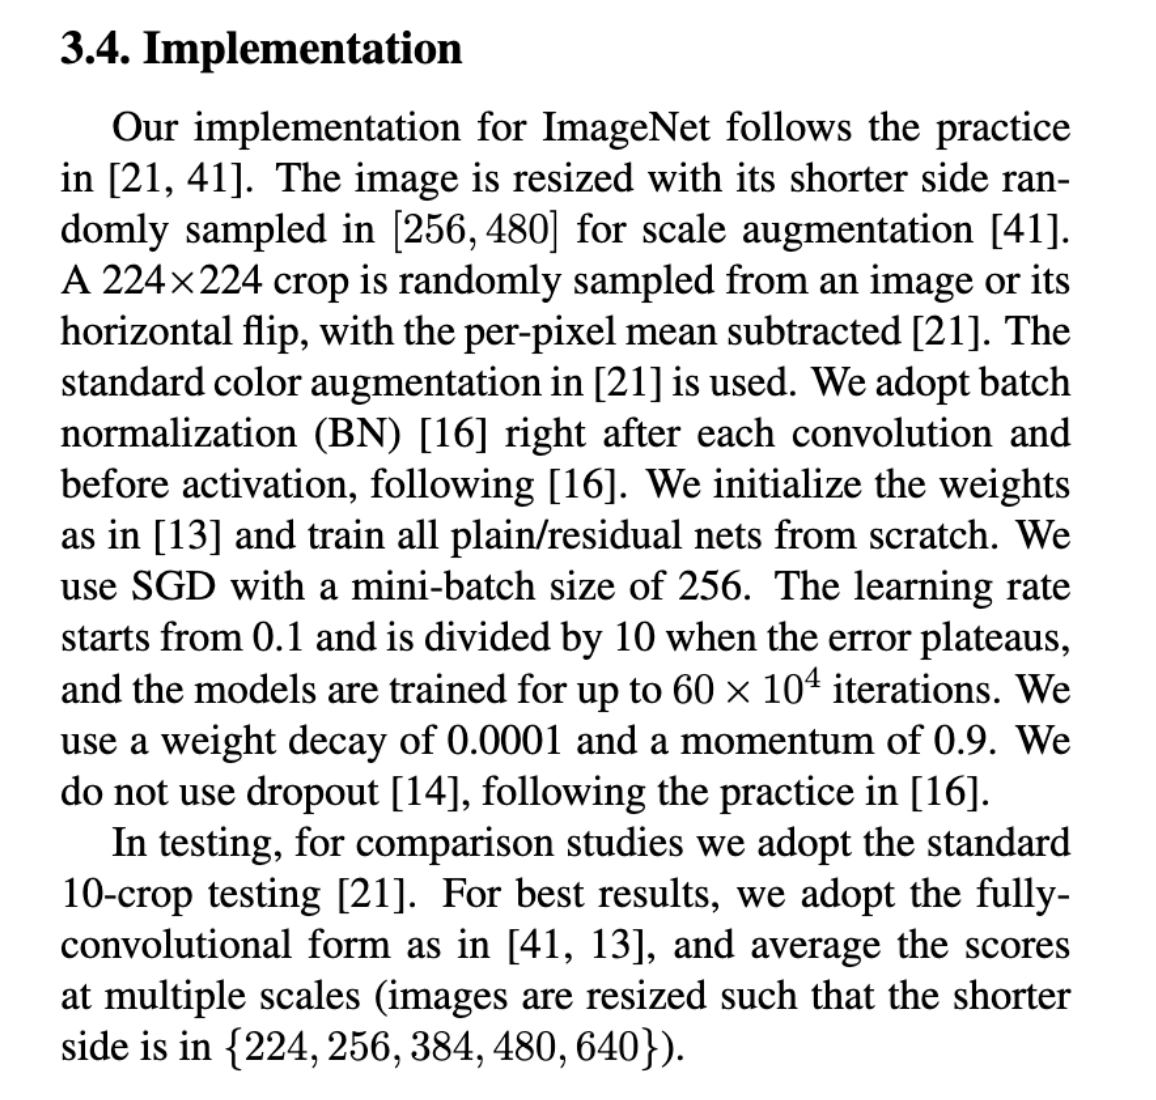

In [2]:
data = Jiu3()
train_loader = DataLoader(
                    data,
                    shuffle=RandomSampler(data),
                    batch_size=10,
                    num_workers=8,
                    pin_memory=True)

weight_dic = {1:0.15,
2:0.09,
3:0.09,
4:0.05,
5:0.13,
6:0.05,
7:0.12,
8:0.13,
9:0.07,
10:0.12}
   

In [20]:
logits.squeeze().shape

torch.Size([10, 256, 256])

In [18]:
data.mask2bbox(logits.squeeze())

AssertionError: 

In [22]:
def mask2bbox(mask):
    assert len(mask.shape) in [2,3]
    # mask: [W,H]
    if len(mask.shape) == 2:
        row = mask.argmax(axis=1)
        col = mask.argmax(axis=0)
        W = len(col[col==col.max()])
        H = len(row[row==row.max()])
        return row.max(), col.max(), W, H
    else:
        

In [40]:
data[1][3]

tensor([465.7100, 314.8600,  13.5800,  15.2800])

In [41]:
data[2][3]

tensor([364.5700,  47.4300, 128.4300,  35.8600])

In [35]:
mask1 = data[1][1]
mask2 = data[2][1]

masks = torch.cat([mask1, mask2],dim=0)

In [51]:
def mask2bbox(mask):
#     assert len(mask.shape) in [3]
    # mask: [bs,W,H]
    row = mask.argmax(axis=1)
    col = mask.argmax(axis=0)
    W = len(col[col==col.max()])
    H = len(row[row==row.max()])
    return row.max(), col.max(), W, H
        

In [10]:
model = Unet()
model.train()

i=0
for imgs, masks, cls, bbox, H, W in train_loader:
    if i==0:
        logits, clf = model(imgs)
        loss1 = multi_class_entropy(imgs, masks.squeeze().long())
        loss2 = lovasz_softmax(imgs, masks.squeeze().long(), per_image=False)
        map_ = mAP(weight_dic, clf.max(dim=1), cls, bbox, bb2_list, img_w, img_h)
    else:
        break

NameError: name 'c_pred' is not defined

In [15]:
clf.max(dim=1)

torch.return_types.max(
values=tensor([0.6544, 1.0974, 0.6126, 0.7082, 0.6801, 0.7037, 0.7620, 0.6021, 0.7324,
        0.8170], grad_fn=<MaxBackward0>),
indices=tensor([3, 3, 7, 3, 7, 3, 3, 7, 3, 3]))